<a href="https://colab.research.google.com/github/rabindra20-git/CS771_projects/blob/main/ass2_experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir= '/content/drive/MyDrive/assn2/train'
reference_dir = '/content/drive/MyDrive/assn2/reference'

In [ ]:
# import cv2
# import numpy as np

def vanish_lines(image, color_range=80):
    # # Read the image
    # image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into channels (H, S, V)
    h, s, v = cv2.split(hsv_image)

    # Find the minimum and maximum pixel values in the V channel
    min_val = np.min(v)
    max_val = np.max(v)

    # Define the color range for darkest colors
    min_color = np.array([min_val - color_range])
    max_color = np.array([min_val + color_range])

    # Create a binary mask for the darkest colors
    mask = cv2.inRange(v, min_color, max_color)

    # Get the pixel value of the top-left corner of the image
    corner_pixel = image[0, 0]

    # Merge the darkest colors with the corner pixel color
    result_image = cv2.bitwise_and(image, image, mask=mask)
    result_image[np.where(mask == 0)] = corner_pixel

    return result_image

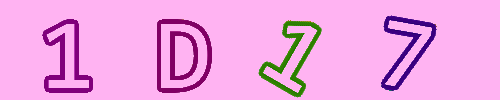

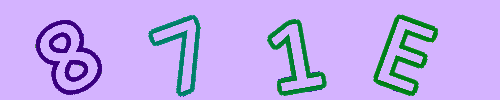

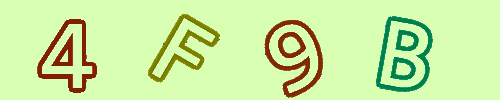

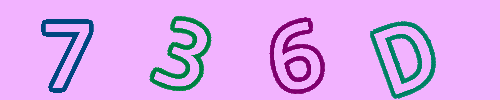

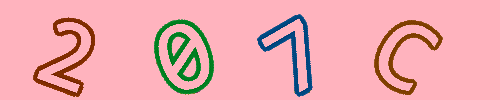

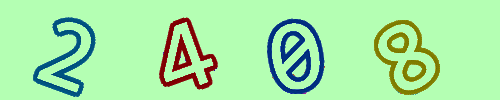

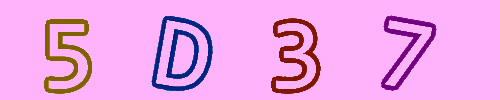

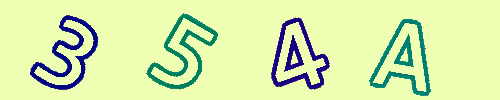

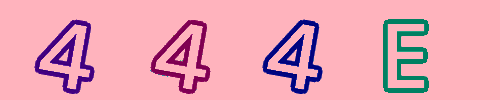

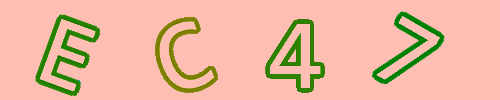

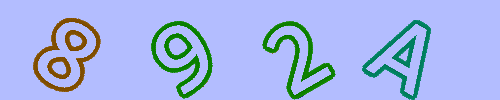

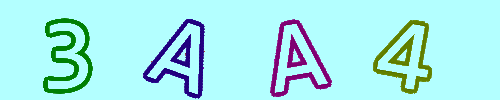

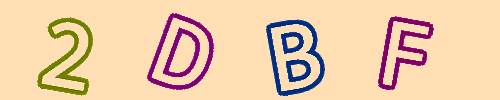

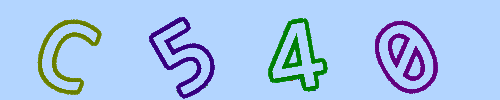

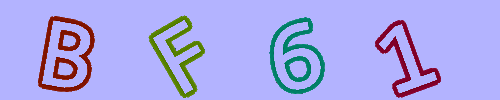

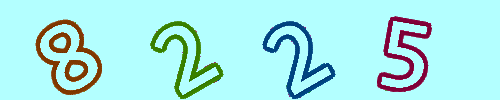

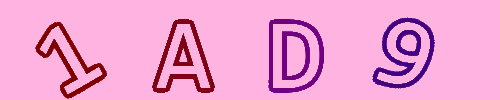

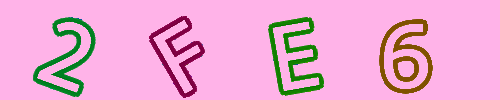

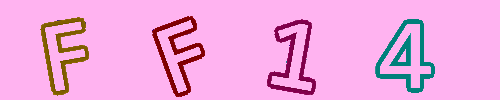

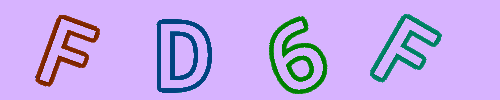

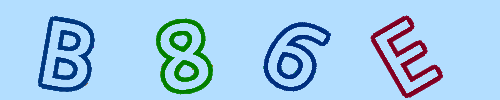

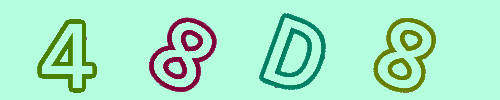

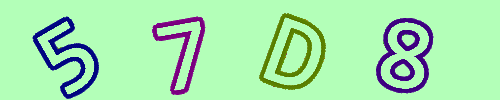

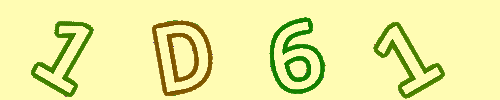

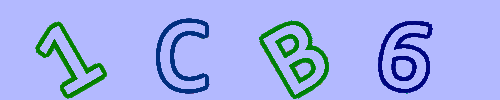

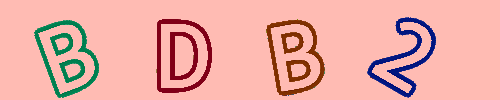

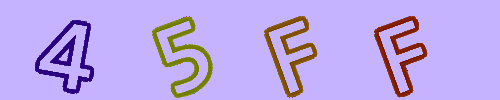

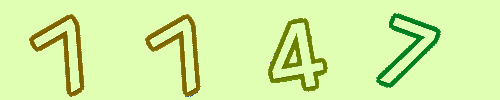

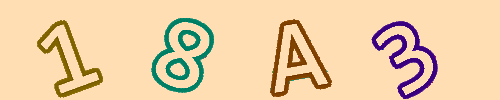

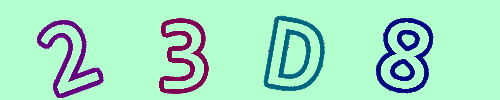

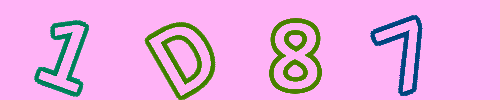

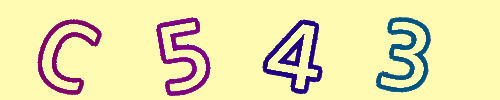

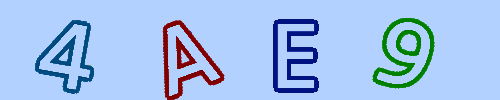

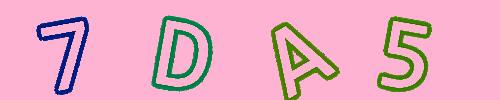

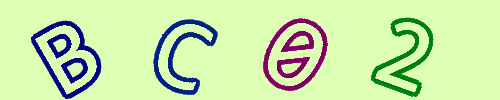

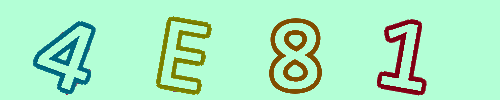

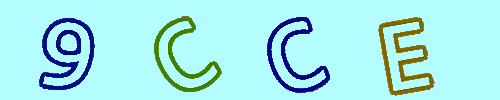

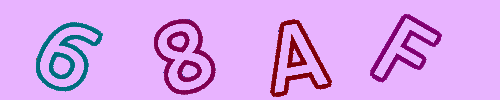

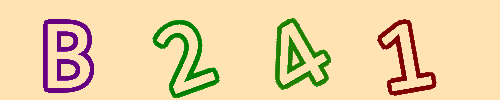

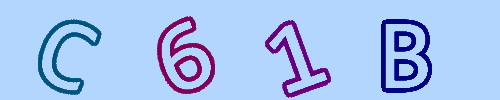

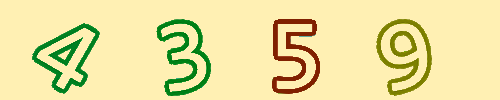

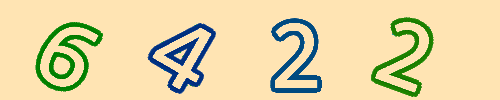

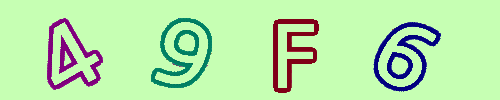

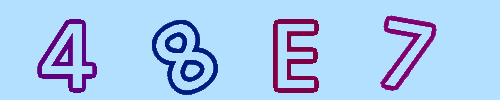

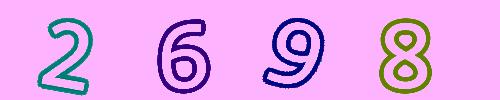

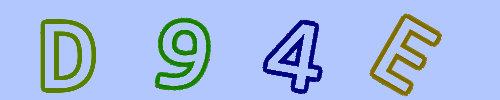

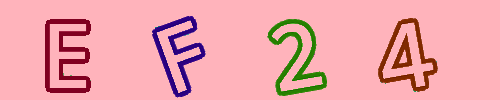

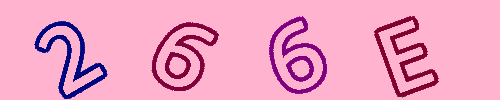

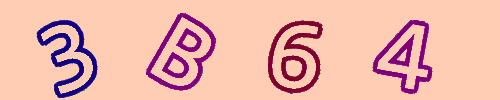

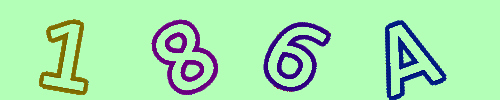

In [ ]:
import os
import random
import cv2
from google.colab.patches import cv2_imshow



# Get a list of all image file names in the directory
image_files = [filename for filename in os.listdir(train_dir) if filename.endswith('.png')]

# Randomly select 50 images from the list
random_images = random.sample(image_files, 50)

# Display the images in the Colab notebook
for image_file in random_images:
    image_path = os.path.join(train_dir, image_file)
    img = cv2.imread(image_path)  # Read image as grayscale
    img = vanish_lines(img)
    cv2_imshow(img)


In [ ]:
def segment_last_letter(image):

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to segment the image into binary form
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the letters
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours from left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Extract the last letter
    last_contour = contours[-1]
    x, y, w, h = cv2.boundingRect(last_contour)
    last_letter = image[y:y+h, x:x+w]

    return last_letter


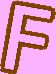

In [ ]:
# Example usage
img= cv2.imread("/content/drive/MyDrive/assn2/train/1777.png")
vanished_lines_image =vanish_lines(img)
last_letter_image= segment_last_letter(vanished_lines_image)
# Display the last letter image
cv2_imshow(last_letter_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2

def segment_last_letter_bw(image):

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to segment the image into binary form
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the letters
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours from left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Extract the last letter
    last_contour = contours[-1]
    x, y, w, h = cv2.boundingRect(last_contour)
    last_letter = gray_image[y:y+h, x:x+w]

    # Apply thresholding to convert to black and white
    _, last_letter_bw = cv2.threshold(last_letter, 127, 255, cv2.THRESH_BINARY)

    # resize the image
    last_letter_bw = cv2.resize(last_letter_bw, (50, 50))

    return last_letter_bw


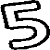

In [ ]:
# Example usage
img= cv2.imread("/content/drive/MyDrive/assn2/train/1001.png")
vanished_lines_image =vanish_lines(img)
last_letter_image_bw= segment_last_letter_bw(vanished_lines_image)
# Display the segmented last letter image in black and white
cv2_imshow(last_letter_image_bw)
cv2.waitKey(0)
cv2.destroyAllWindows()

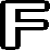

In [ ]:
# Example usage
image= cv2.imread("/content/drive/MyDrive/assn2/reference/F.png")

cropped_image = segment_last_letter_bw(image)
cv2_imshow(cropped_image)

In [ ]:
images = []
a=1
files = sorted(os.listdir(train_dir), key=lambda x: int(x[:-4]) if x.endswith('.png') else a==1)
for filename in files:
    if filename.endswith('.png'):  # assuming all images are in JPG format
        img_path = os.path.join(train_dir, filename)
        img = cv2.imread(img_path) # read image as grayscale
        img= vanish_lines(img)
        img = segment_last_letter_bw(img)

        images.append(img)
preprocessed_images= np.array(images)

In [ ]:
labels_file = os.path.join(train_dir, 'labels.txt')

with open(labels_file, 'r') as file:
    labels = [line.strip() for line in file.readlines()]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the preprocessed images and labels into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Reshape the train and test data to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Create an SVM classifier and fit it to the training data
model = SVC()
model.fit(X_train_2d, y_train)

# Perform predictions on the test data
y_pred = model.predict(X_test_2d)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9975


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the preprocessed images and labels into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Reshape the train and test data to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Create a KNN classifier and fit it to the training data
model = KNeighborsClassifier()
model.fit(X_train_2d, y_train)

# Perform predictions on the test data
y_pred = model.predict(X_test_2d)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9975


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the preprocessed images and labels into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Reshape the train and test data to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Create a logistic regression classifier and fit it to the training data
model = LogisticRegression()
model.fit(X_train_2d, y_train)

# Perform predictions on the test data
y_pred = model.predict(X_test_2d)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [ ]:
import cv2
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

# Initialize the reference images and labels
reference_images = []
reference_labels = []

# Load the reference images and extract labels from filenames
for filename in sorted(os.listdir(reference_dir)):
    if filename.endswith('.png'):
        img_path = os.path.join(reference_dir, filename)
        img = cv2.imread(img_path, 0)  # Load as grayscale
        reference_images.append(img)

        # Extract the label from the filename
        label_str = os.path.splitext(filename)[0]  # Get the filename without extension
        if label_str.isdigit():
            label = int(label_str)
        else:
            label = ord(label_str) - ord('A') + 10
        reference_labels.append(label)

# Create rotated versions of the reference images
rotated_reference_images = []
rotation_angles = [0, 10, -10, 20, -20, 30, -30]
for img in reference_images:
    rotated_images = [img]
    for angle in rotation_angles:
        M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        rotated_images.append(rotated_img)
    rotated_reference_images.extend(rotated_images)

# Prepare the list of labels for the rotated reference images
rotated_reference_labels = []
for _ in range(16):
    rotated_reference_labels.extend(reference_labels)

# Rest of the code for classification and labeling remains the same
# Function to find the closest match for each preprocessed image
def find_closest_match(image):
    distances = pairwise_distances_argmin_min(image, rotated_reference_images, metric='euclidean')
    closest_index = distances[0][0]
    closest_label = rotated_reference_labels[closest_index]
    return closest_label

# Classify preprocessed images
predictions = []
for img in preprocessed_images_2d:
    label = find_closest_match(img)
    predictions.append(label)



# Map labels to 'ODD' or 'EVEN' based on the hexadecimal number
output_labels = []
for prediction in predictions:
    if prediction % 2 == 0:
        output_labels.append('EVEN')
    else:
        output_labels.append('ODD')

# Print the predictions for the preprocessed images
for i, img in enumerate(preprocessed_images):
    print("Image:", i)
    print("Prediction:", output_labels[i])

NameError: ignored